In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

import warnings
warnings.filterwarnings("ignore")

<p style="background-color:#C7B299; font-family:'Courier New', monospace;  font-size:140%; text-align:center; padding: 10px; border-radius: 20px;"> <b>📖 Reading and Cleaning 🧹</b> </p>

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">Reading</p>

In [2]:
path = "/kaggle/input/playground-series-s4e2/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")
org = pd.read_csv("/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv")


In [3]:
train.drop(["id"], axis=1, inplace=True)
train = pd.concat([train, org], axis=0)
test.drop(["id"], axis=1, inplace=True)

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">Cleaning</p>

In [4]:
train.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [5]:
train.duplicated().sum()

24

In [6]:
train = train.drop_duplicates()

In [7]:
train.nunique()

Gender                               2
Age                               1739
Height                            1862
Weight                            2014
family_history_with_overweight       2
FAVC                                 2
FCVC                               975
NCP                                740
CAEC                                 4
SMOKE                                2
CH2O                              1568
SCC                                  2
FAF                               1408
TUE                               1329
CALC                                 4
MTRANS                               5
NObeyesdad                           7
dtype: int64

In [8]:
num_cols = [col for col in train.columns if (train[col].dtype in ["int64","float64"]) & (train[col].nunique()>2) and (col != 'id')]
num_cols

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [9]:
cat_cols = [col for col in train.columns if (train[col].nunique() <= 5)]
cat_cols

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS']

In [10]:
cat_cols_test = [col for col in test.columns if (test[col].nunique() <= 5)]
cat_cols_test

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS']

<p style="background-color:#C7B299; font-family:'Courier New', monospace;  font-size:140%; text-align:center; padding: 10px; border-radius: 20px;"> <b>📊 Exploratory Data Analysis (EDA) 📊</b> </p>

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">Target</p>

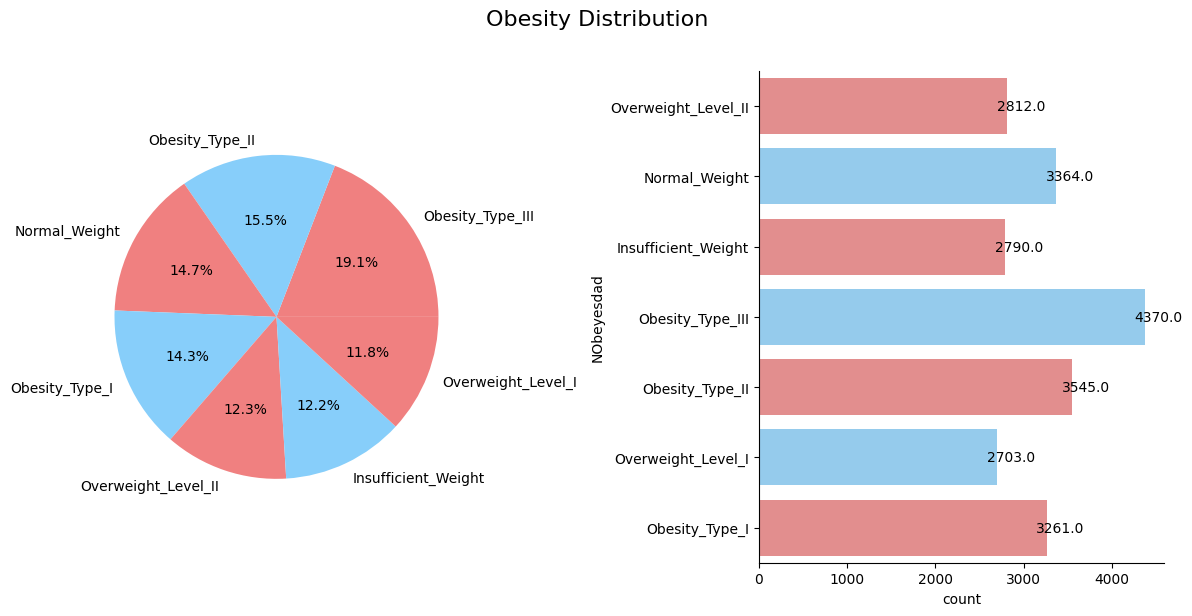

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6)) 

Obesity_counts = train['NObeyesdad'].value_counts()

axes[0].pie(Obesity_counts, labels=Obesity_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])

sns.countplot(data=train, y='NObeyesdad', palette=['lightcoral', 'lightskyblue'], ax=axes[1])

for p in axes[1].patches:
    axes[1].annotate(f"{p.get_width()}", (p.get_width(), p.get_y() + p.get_height() / 2.), va='center', ha='center', xytext=(10, 0), textcoords='offset points')

fig.suptitle("Obesity Distribution", fontsize=16, y=1.02)

sns.despine(right=True, ax=axes[1])

plt.tight_layout()
plt.show()

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">Categorical</p>

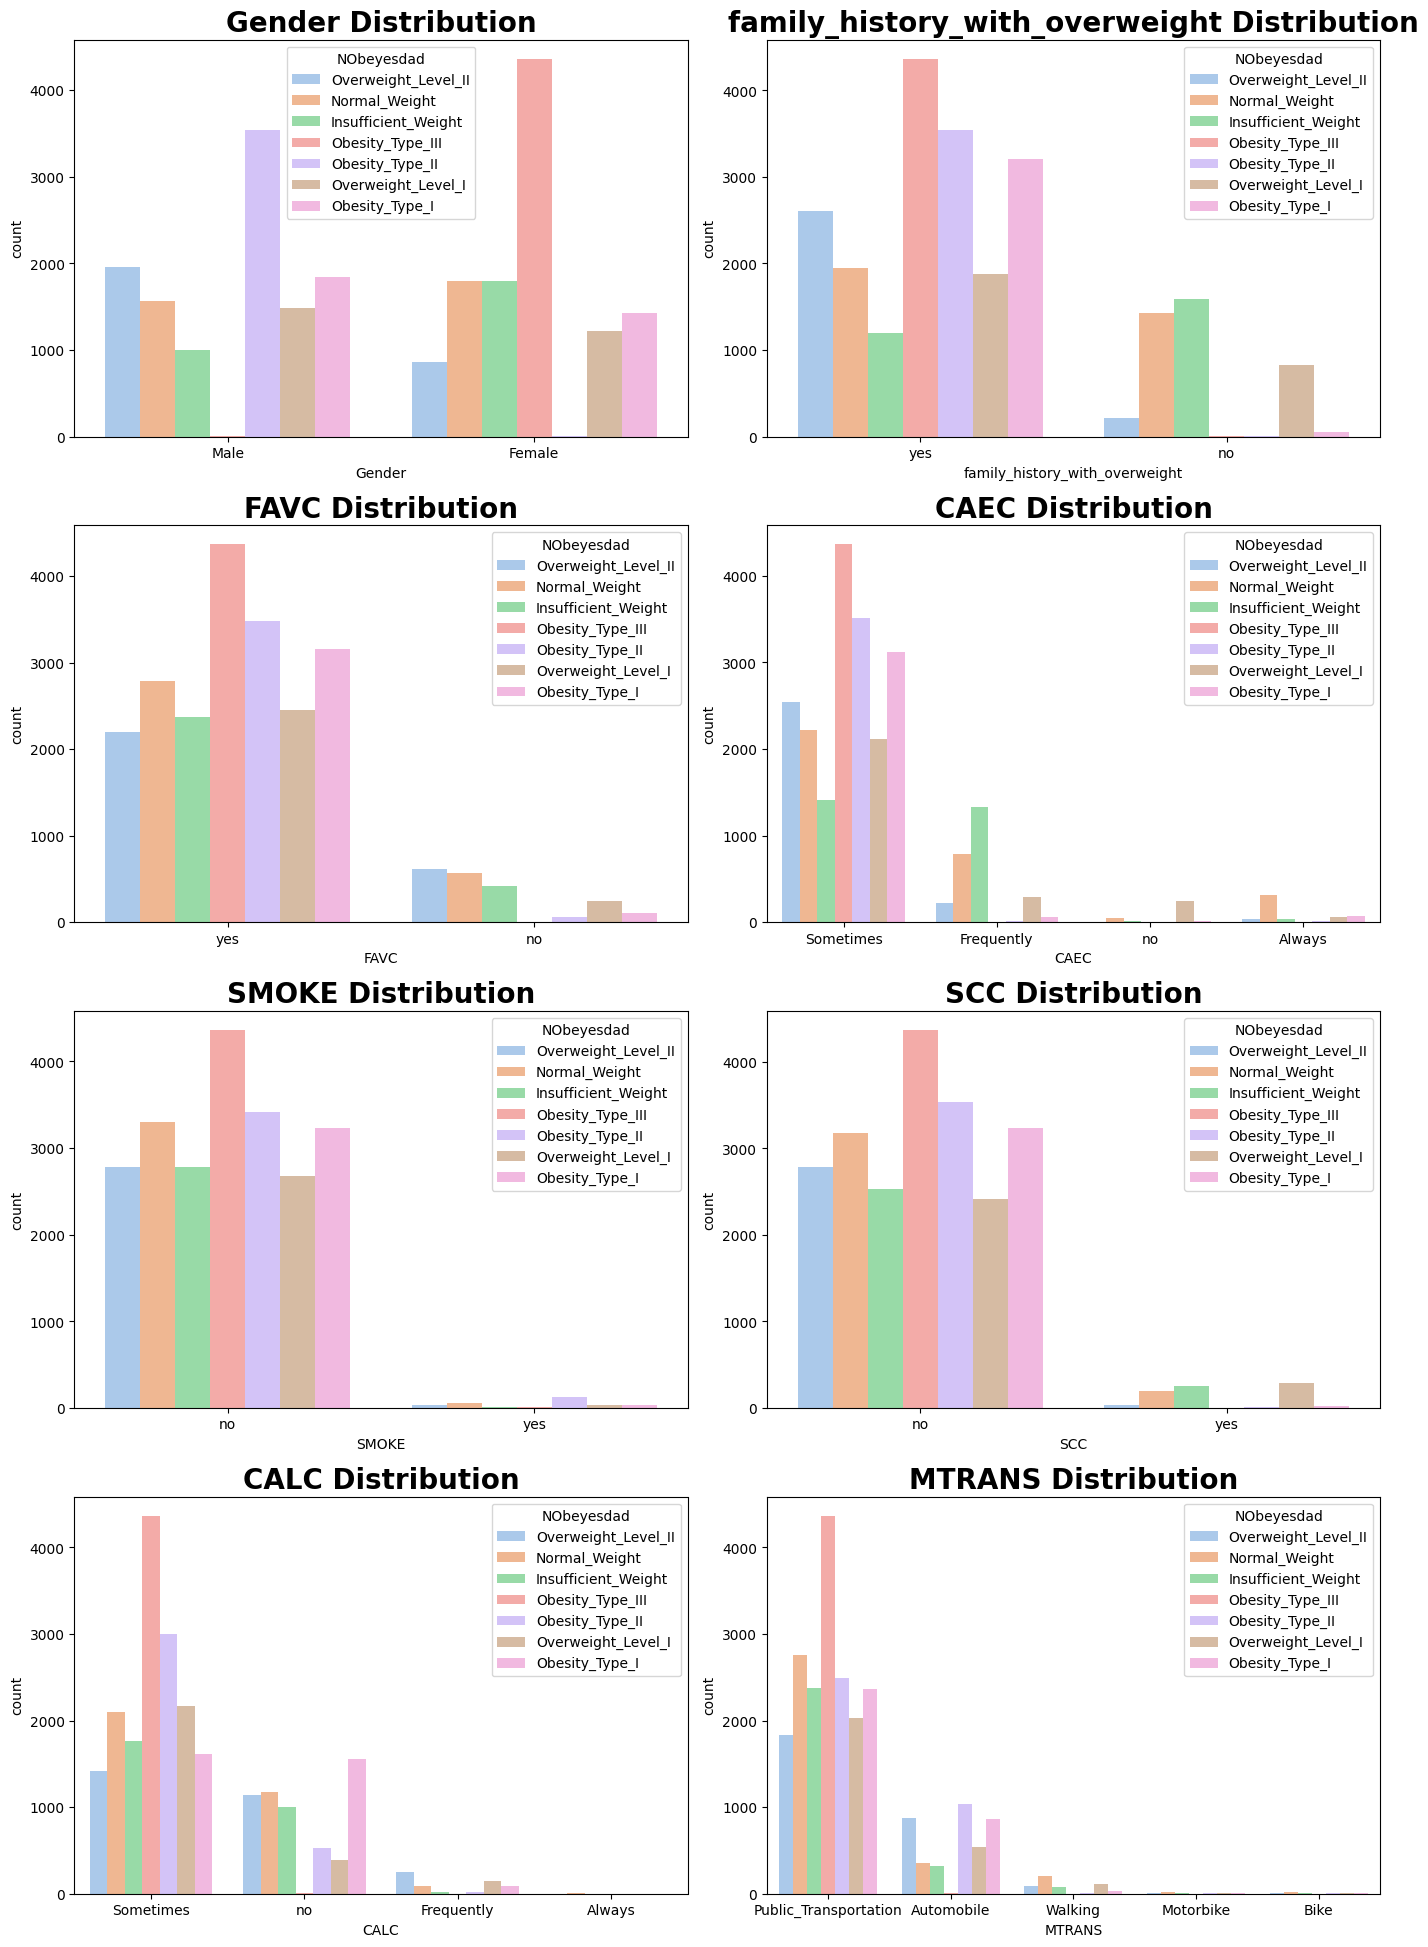

In [12]:
plt.figure(figsize=(14,len(cat_cols)*3))
for idx,column in enumerate(cat_cols):
    plt.subplot(len(cat_cols)//2+1,2,idx+1)
    sns.countplot(hue="NObeyesdad", x=column, data=train, palette="pastel")
    plt.title(f"{column} Distribution",weight='bold',fontsize=20)
    plt.tight_layout()

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">Numerical</p>

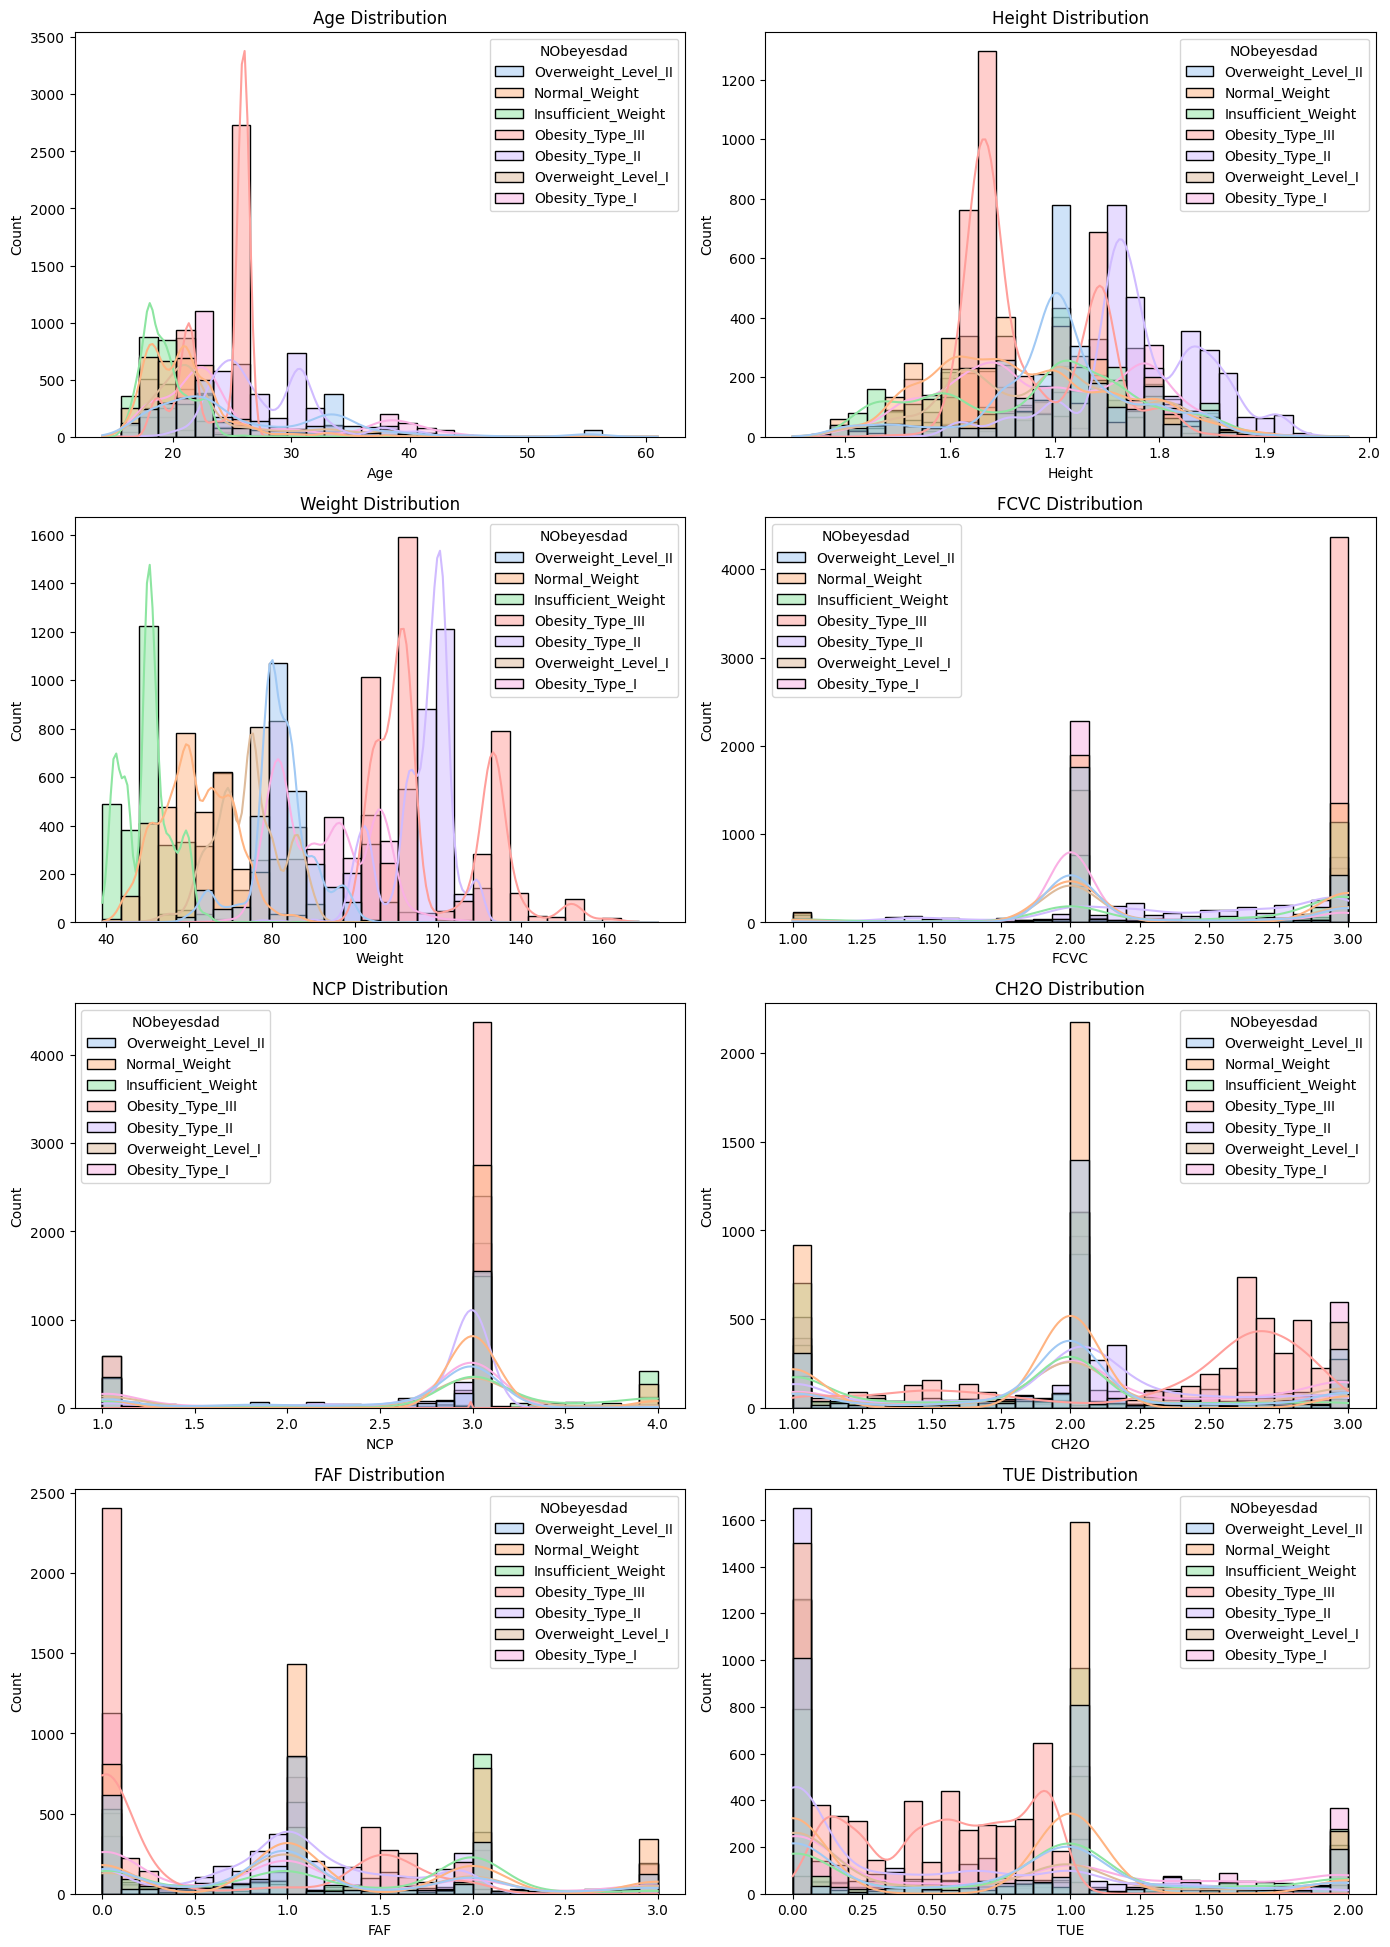

In [13]:
plt.figure(figsize=(14,len(num_cols)*3))
for idx,column in enumerate(num_cols):
    plt.subplot(len(num_cols)//2+1,2,idx+1)
    sns.histplot(x=column, hue="NObeyesdad", data=train,bins=30,kde=True, palette="pastel")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

<p style="background-color:#C7B299; font-family:'Courier New', monospace;  font-size:140%; text-align:center; padding: 10px; border-radius: 20px;"> <b>🛠️ Feature Engineering 🛠️</b> </p>

In [14]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
check_outlier(train, num_cols)

False

In [15]:
train = pd.get_dummies(train, columns=cat_cols, drop_first=True)
test = pd.get_dummies(test, columns=cat_cols_test, drop_first=True)

<p style="background-color:#C7B299; font-family:'Courier New', monospace;  font-size:140%; text-align:center; padding: 10px; border-radius: 20px;"> <b>🛠️ Modeling 🤖</b> </p>

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">Split</p>

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X = train.drop("NObeyesdad", axis=1)
y = train["NObeyesdad"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state = 42)

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">Feature Importance</p>

In [17]:
from lightgbm import LGBMClassifier

lgb_params = {
    'objective': 'multiclass',
    'num_class': len(set(y_train)),
    'verbose': 0,
    'metric': 'multi_logloss'
}

lgb = LGBMClassifier(**lgb_params)
lgb.fit(X_train, y_train)
y_test_pred = lgb.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy Score: {accuracy_test}')

Test Accuracy Score: 0.9117968920989276


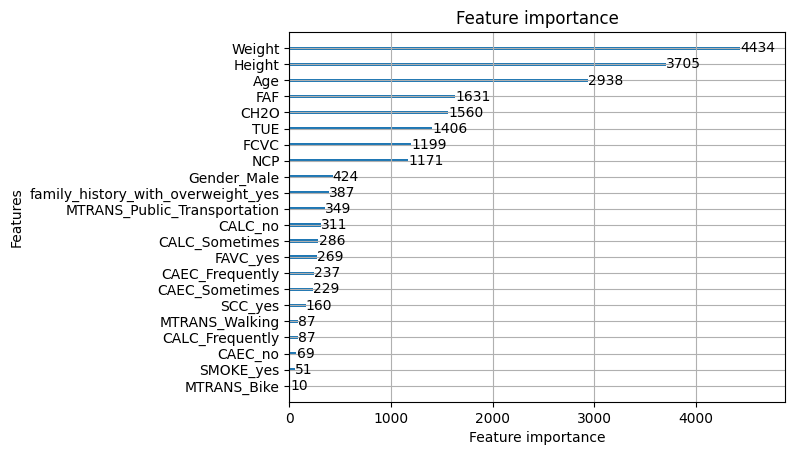

In [18]:
import lightgbm
lightgbm.plot_importance(lgb);

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">LightGBM Classifier</p>

In [19]:
best_params = {'max_depth': 7, 'learning_rate': 0.021049270942043768, 
               'n_estimators': 500, 'subsample': 0.24920955798329597
             }
lgb_model = LGBMClassifier(**best_params)
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 18276, number of used features: 23
[LightGBM] [Info] Start training from score -2.109885
[LightGBM] [Info] Start training from score -1.917163
[LightGBM] [Info] Start training from score -1.958187
[LightGBM] [Info] Start training from score -1.858972
[LightGBM] [Info] Start training from score -1.655114
[LightGBM] [Info] Start training from score -2.127182
[LightGBM] [Info] Start training from score -2.083169
[LightGBM

<p style="background-color:#C7B299; font-family:'Courier New', monospace;  font-size:140%; text-align:center; padding: 10px; border-radius: 20px;"> <b>🕵️‍ Prediction 🔮</b> </p>

In [20]:
y_pred_submission = lgb_model.predict(test)  
submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')  
submission['NObeyesdad'] = y_pred_submission  
submission.to_csv('submission.csv', index=False)

submission

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Overweight_Level_I
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight
